# WordleBot: Using Spectral Clustering and Reinforcement Learning to Win at Wordle
By Dan Schauder

## Background

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a simple word game developed by Josh Wardle. After reading about it in the [New York Times](https://www.powerlanguage.co.uk/wordle/), I gave it a try and was immediately hooked. My wife and I have developed a bit of a rivalry, comparing our guess count each day, and I thought it would be fun to build a bot to add to the competition. In this post, I'll review the rules of Wordle and walk through my bot's design and performance over 1,000 simulated games. The main ML/AI techniques used include [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering) and [Q Learning](https://en.wikipedia.org/wiki/Q-learning).

**TLDR;**
* I used Machine Learning to build a bot to play Wordle on hard mode.
* Over 1,000 simulated games, the bot took an **average of 3.767 guesses** to discover the correct word.
* The bot lost 8 out of the 1,000 simulated games for an overall **win rate of 99.2%**.

## Wordle Primer / Rule Review

For those unfamiliar with Wordle, here's a screenshot from the [Wordle](https://www.powerlanguage.co.uk/wordle/) page describing the rules:

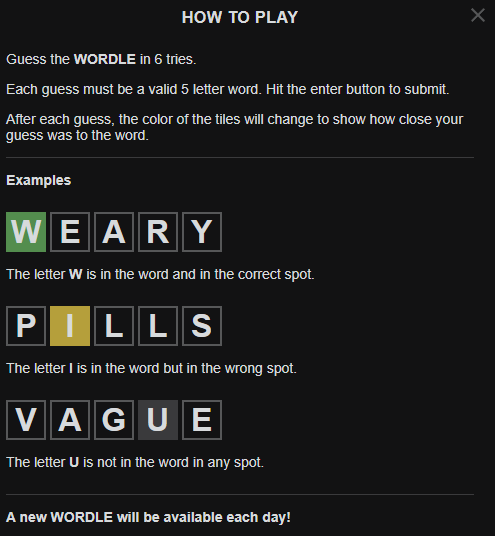


It's not technically necessary to use the information revealed by the color of the tiles. For instance, in the "Pills" guess above, you're not required to use an "I" in your next guess, even though you know the correct solution contains an "I". It can actually be more advantageous in some cases to ignore this information to rule out as many potential words as possible. If you play the game on **hard mode**, however, you are **required** to use the feedback from each guess to inform your next guesses. My bot plays on hard mode.

## Related Work

A quick scan of the blogosphere revealed that I wasn't the only one intrigued by using Data Science to tackle the Wordle challenge.

* Matt Rickard [described a greedy approach](https://matt-rickard.com/wordle-whats-the-best-starting-word/) to determine the "best" starting guess for Wordle based on eliminating as many answer choices as possible (he landed on "SOARE", which I didn't even know was a word). 
* Fellow Georgia Techie Mark Scherschel II [proposed using pairwise distances to measure word centrality](https://medium.com/@schersch/an-informed-first-wordle-d2b3f001cd1a), choosing "TARES" as the best starting word choice due to its relative proximity to other words.

I wanted to incorporate and extend these ideas in my bot's design to build an autonomous agent, focusing less on the **best first word** and more on a **policy** governing the **best next guess** to  navigate from one state of play to the next. Ideally, this agent would learn from its experiences and improve its performance as it played more and more games.

## Methods

### Source Data

While there are more than 12,000 5-letter words in the English language, many of them are archaic or esoteric. The creator of Wordle limited the answer bank to ~2,300 commonly used words in everyday language. I manually copied the 2,300-word bank from the Wordle source code to train my bot.

### Word Similarity Graph

The set of feasible words is organized in an undirected [graph data structure](https://en.wikipedia.org/wiki/Graph_(abstract_data_type). Each "node" or "vertex" is a word, and each "edge" or "link" between words is weighted by a simple similarity score. The score is composed of 1 point for each common letter between two words and an additional point if the common letter is also in the same position in the word.

Pairwise similarity scores are computed for all words in the smaller answer bank and stored in a symmetric adjacency matrix.

### Spectral Clustering

Spectral Clustering is used to partition the graph into $k$ "communities" (groups of similar nodes). I used a $k$ value of 5. I'll not delve too deeply into the weeds for this post, but if you haven't come across this algorithm, you can think of it as K-Means for similarity graphs. For those interested in reading further, [check out this Wikipedia post](https://en.wikipedia.org/wiki/Spectral_clustering) (good jumping off point).

### Q Learning

Q Learning is a form of Reinforcement Learning that seeks to learn a policy $\pi$ based on experiences (in the form of transitions between states, actions, and resulting rewards). One challenge in Q Learning is to define a discrete state space such that an agent can gain sufficient experience through experimentation to learn the "best" action in a given situation to maximize expected reward. Another challenge is to establish a reward system that effectively balances short-term and long-term rewards (e.g., it's easier to train a bot to eat a candy bar than to save for college).

In this exercise, I define state by discretizing the distribution of nodes among the $k$ communities. With $k=5$, this resulted in 126 possible states.

Actions were defined as **which community** the bot should choose its next word guess from.

Rewards were defined as the sum of the following 3 components: a shrinkage factor ($s$), a correctness factor ($c$), and a winning bonus ($b$).

The shrinkage factor is given by:
$$
s=\frac{feasible \ nodes \  before \ guess}{feasible \ nodes \ after \ guess}
$$

The correctness factor is defined as 2 points for each green letter (correct letter in the correct position), 1 point for each yellow letter (correct letter, wrong position), and 0 points for each grey letter (letter not in the correct word).

The bot earns a big bonus of 1,000 points for each winning guess.

### Overall Strategy

For each game, a Grader class randomly selects a word from the bank of 2,315 common 5-letter words. The bot then uses an iterative approach to make guesses. In each iteration, the bot performs the following operations:

* partitions the graph using spectral clustering on the set of remaining feasible words
* discretizes the distribution of words among clusters
* uses the Q Learner to select a cluster from which to draw the next guess
* chooses the guess as the "centroid" of the chosen cluster (word having the highest total similarity score within the cluster)
* passes the guess to the Grader class which evaluates the guess and returns feedback in the form of a vector of scores for each letter (2 for green, 1 for yellow, 0 for grey)
* filters the graph to exclude infeasible words based on feedback from the grader
* calculates a reward to pass to the Q Learner in the next iteration

The bot terminates its iterations when it guesses the correct word.

With this strategy, I make the bot play 1,000 games and record the guess count for each.

## Performance

Over the 1,000 games, the bot achieves an average guess count of 3.767. It "loses" 8 times (needing more than 6 guesses to identify the correct word) for an overall win rate of 99.2%. Here's a chart showing the bot's performance over its 1,000-game epoch.

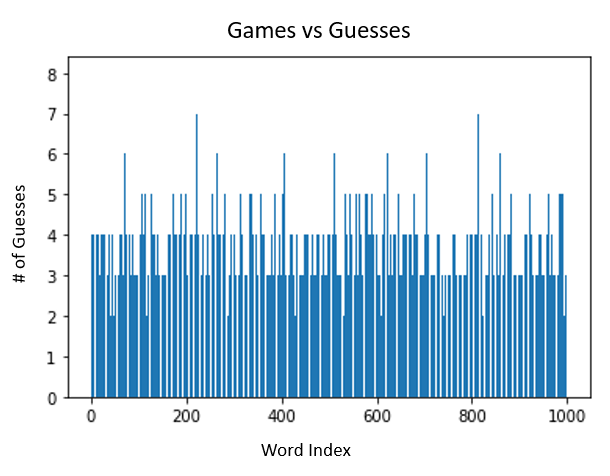

## Conclusions

I was pleasantly surprised with my bot's performance in general. My own Wordle average hovers between 3 and 4, so the bot can definitely hold its own against a human!

That said, there's plenty of room for improvement. Calculating and storing similarity scores is by far the least computationally efficient part of my bot's current design, as it requires 5,359,225 pairwise similarity scores to be computed for the 2,315 words. Since the graph is symmetric, technically the ~5 million similarity computations could be halved to ~2.5 million. Because the scores never change, they really only ever need to be computed once (while my current design recomputes scores unnecessarily out of expedience). The entire simulation takes about 45 minutes to run in a Google Colab environment, and I'm confident this runtime could be substantially decreased with some refactoring.

Additionally, there are many parameters which could be tuned. For example, I arbitrarily set the number of communities to 5 for this exercise and achieved results that were good enough for me, but there may be some other optimal number of communities. 

Lastly, I suspect the Q Learning part of the bot may be overkill. I didn't observe the reduction in the number of guesses per game I expected to see as the bot gained experience, suggesting there wasn't much of a "convergence" happening. For a fun short project though, I'm really pleased with how it all turned out.

## Appendix: Code

### Setup

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering

In [ ]:
def count_states(m,n):
  return np.math.factorial(m+n-1)/(np.math.factorial(n-1)*np.math.factorial(m))

count_states(5,5)

126.0

### Interpreter Class

The below cell defines an Interpreter class with the following responsibilities:
* Initialize the starting word bank
* Perform spectal clustering on the word bank to partition it into communities of similar words
* Translate the distribution of words within clusters into a discrete state using $k$ quantiles
* Pass the discrete state label to a Q Learner class along with the reward from the learner's previous action (quantile guess)
* Based on the Q Learner's chosen quantile, choose the word having the highest total similarity score within the quantile as the bot's next guess
* Pass word guesses to a Grader class
* Use information returned from the Grader class to filter the word bank, compute a reward, and repeat the above steps until convergence

I manually copied the answer bank below from the Wordle source code. 

**Spoiler alert - the answers are listed in date order, so don't look too closely at the world list if you don't want to spoil the game for yourself.**

In [ ]:
class Interpreter():
  def __init__(self, k=5):
    self.words_full=["cigar","rebut","sissy","humph","awake","blush","focal","evade","naval","serve","heath","dwarf","model","karma","stink","grade","quiet","bench","abate","feign","major","death","fresh","crust","stool","colon","abase","marry","react","batty","pride","floss","helix","croak","staff","paper","unfed","whelp","trawl","outdo","adobe","crazy","sower","repay","digit","crate","cluck","spike","mimic","pound","maxim","linen","unmet","flesh","booby","forth","first","stand","belly","ivory","seedy","print","yearn","drain","bribe","stout","panel","crass","flume","offal","agree","error","swirl","argue","bleed","delta","flick","totem","wooer","front","shrub","parry","biome","lapel","start","greet","goner","golem","lusty","loopy","round","audit","lying","gamma","labor","islet","civic","forge","corny","moult","basic","salad","agate","spicy","spray","essay","fjord","spend","kebab","guild","aback","motor","alone","hatch","hyper","thumb","dowry","ought","belch","dutch","pilot","tweed","comet","jaunt","enema","steed","abyss","growl","fling","dozen","boozy","erode","world","gouge","click","briar","great","altar","pulpy","blurt","coast","duchy","groin","fixer","group","rogue","badly","smart","pithy","gaudy","chill","heron","vodka","finer","surer","radio","rouge","perch","retch","wrote","clock","tilde","store","prove","bring","solve","cheat","grime","exult","usher","epoch","triad","break","rhino","viral","conic","masse","sonic","vital","trace","using","peach","champ","baton","brake","pluck","craze","gripe","weary","picky","acute","ferry","aside","tapir","troll","unify","rebus","boost","truss","siege","tiger","banal","slump","crank","gorge","query","drink","favor","abbey","tangy","panic","solar","shire","proxy","point","robot","prick","wince","crimp","knoll","sugar","whack","mount","perky","could","wrung","light","those","moist","shard","pleat","aloft","skill","elder","frame","humor","pause","ulcer","ultra","robin","cynic","agora","aroma","caulk","shake","pupal","dodge","swill","tacit","other","thorn","trove","bloke","vivid","spill","chant","choke","rupee","nasty","mourn","ahead","brine","cloth","hoard","sweet","month","lapse","watch","today","focus","smelt","tease","cater","movie","lynch","saute","allow","renew","their","slosh","purge","chest","depot","epoxy","nymph","found","shall","harry","stove","lowly","snout","trope","fewer","shawl","natal","fibre","comma","foray","scare","stair","black","squad","royal","chunk","mince","slave","shame","cheek","ample","flair","foyer","cargo","oxide","plant","olive","inert","askew","heist","shown","zesty","hasty","trash","fella","larva","forgo","story","hairy","train","homer","badge","midst","canny","fetus","butch","farce","slung","tipsy","metal","yield","delve","being","scour","glass","gamer","scrap","money","hinge","album","vouch","asset","tiara","crept","bayou","atoll","manor","creak","showy","phase","froth","depth","gloom","flood","trait","girth","piety","payer","goose","float","donor","atone","primo","apron","blown","cacao","loser","input","gloat","awful","brink","smite","beady","rusty","retro","droll","gawky","hutch","pinto","gaily","egret","lilac","sever","field","fluff","hydro","flack","agape","wench","voice","stead","stalk","berth","madam","night","bland","liver","wedge","augur","roomy","wacky","flock","angry","bobby","trite","aphid","tryst","midge","power","elope","cinch","motto","stomp","upset","bluff","cramp","quart","coyly","youth","rhyme","buggy","alien","smear","unfit","patty","cling","glean","label","hunky","khaki","poker","gruel","twice","twang","shrug","treat","unlit","waste","merit","woven","octal","needy","clown","widow","irony","ruder","gauze","chief","onset","prize","fungi","charm","gully","inter","whoop","taunt","leery","class","theme","lofty","tibia","booze","alpha","thyme","eclat","doubt","parer","chute","stick","trice","alike","sooth","recap","saint","liege","glory","grate","admit","brisk","soggy","usurp","scald","scorn","leave","twine","sting","bough","marsh","sloth","dandy","vigor","howdy","enjoy","valid","ionic","equal","unset","floor","catch","spade","stein","exist","quirk","denim","grove","spiel","mummy","fault","foggy","flout","carry","sneak","libel","waltz","aptly","piney","inept","aloud","photo","dream","stale","vomit","ombre","fanny","unite","snarl","baker","there","glyph","pooch","hippy","spell","folly","louse","gulch","vault","godly","threw","fleet","grave","inane","shock","crave","spite","valve","skimp","claim","rainy","musty","pique","daddy","quasi","arise","aging","valet","opium","avert","stuck","recut","mulch","genre","plume","rifle","count","incur","total","wrest","mocha","deter","study","lover","safer","rivet","funny","smoke","mound","undue","sedan","pagan","swine","guile","gusty","equip","tough","canoe","chaos","covet","human","udder","lunch","blast","stray","manga","melee","lefty","quick","paste","given","octet","risen","groan","leaky","grind","carve","loose","sadly","spilt","apple","slack","honey","final","sheen","eerie","minty","slick","derby","wharf","spelt","coach","erupt","singe","price","spawn","fairy","jiffy","filmy","stack","chose","sleep","ardor","nanny","niece","woozy","handy","grace","ditto","stank","cream","usual","diode","valor","angle","ninja","muddy","chase","reply","prone","spoil","heart","shade","diner","arson","onion","sleet","dowel","couch","palsy","bowel","smile","evoke","creek","lance","eagle","idiot","siren","built","embed","award","dross","annul","goody","frown","patio","laden","humid","elite","lymph","edify","might","reset","visit","gusto","purse","vapor","crock","write","sunny","loath","chaff","slide","queer","venom","stamp","sorry","still","acorn","aping","pushy","tamer","hater","mania","awoke","brawn","swift","exile","birch","lucky","freer","risky","ghost","plier","lunar","winch","snare","nurse","house","borax","nicer","lurch","exalt","about","savvy","toxin","tunic","pried","inlay","chump","lanky","cress","eater","elude","cycle","kitty","boule","moron","tenet","place","lobby","plush","vigil","index","blink","clung","qualm","croup","clink","juicy","stage","decay","nerve","flier","shaft","crook","clean","china","ridge","vowel","gnome","snuck","icing","spiny","rigor","snail","flown","rabid","prose","thank","poppy","budge","fiber","moldy","dowdy","kneel","track","caddy","quell","dumpy","paler","swore","rebar","scuba","splat","flyer","horny","mason","doing","ozone","amply","molar","ovary","beset","queue","cliff","magic","truce","sport","fritz","edict","twirl","verse","llama","eaten","range","whisk","hovel","rehab","macaw","sigma","spout","verve","sushi","dying","fetid","brain","buddy","thump","scion","candy","chord","basin","march","crowd","arbor","gayly","musky","stain","dally","bless","bravo","stung","title","ruler","kiosk","blond","ennui","layer","fluid","tatty","score","cutie","zebra","barge","matey","bluer","aider","shook","river","privy","betel","frisk","bongo","begun","azure","weave","genie","sound","glove","braid","scope","wryly","rover","assay","ocean","bloom","irate","later","woken","silky","wreck","dwelt","slate","smack","solid","amaze","hazel","wrist","jolly","globe","flint","rouse","civil","vista","relax","cover","alive","beech","jetty","bliss","vocal","often","dolly","eight","joker","since","event","ensue","shunt","diver","poser","worst","sweep","alley","creed","anime","leafy","bosom","dunce","stare","pudgy","waive","choir","stood","spoke","outgo","delay","bilge","ideal","clasp","seize","hotly","laugh","sieve","block","meant","grape","noose","hardy","shied","drawl","daisy","putty","strut","burnt","tulip","crick","idyll","vixen","furor","geeky","cough","naive","shoal","stork","bathe","aunty","check","prime","brass","outer","furry","razor","elect","evict","imply","demur","quota","haven","cavil","swear","crump","dough","gavel","wagon","salon","nudge","harem","pitch","sworn","pupil","excel","stony","cabin","unzip","queen","trout","polyp","earth","storm","until","taper","enter","child","adopt","minor","fatty","husky","brave","filet","slime","glint","tread","steal","regal","guest","every","murky","share","spore","hoist","buxom","inner","otter","dimly","level","sumac","donut","stilt","arena","sheet","scrub","fancy","slimy","pearl","silly","porch","dingo","sepia","amble","shady","bread","friar","reign","dairy","quill","cross","brood","tuber","shear","posit","blank","villa","shank","piggy","freak","which","among","fecal","shell","would","algae","large","rabbi","agony","amuse","bushy","copse","swoon","knife","pouch","ascot","plane","crown","urban","snide","relay","abide","viola","rajah","straw","dilly","crash","amass","third","trick","tutor","woody","blurb","grief","disco","where","sassy","beach","sauna","comic","clued","creep","caste","graze","snuff","frock","gonad","drunk","prong","lurid","steel","halve","buyer","vinyl","utile","smell","adage","worry","tasty","local","trade","finch","ashen","modal","gaunt","clove","enact","adorn","roast","speck","sheik","missy","grunt","snoop","party","touch","mafia","emcee","array","south","vapid","jelly","skulk","angst","tubal","lower","crest","sweat","cyber","adore","tardy","swami","notch","groom","roach","hitch","young","align","ready","frond","strap","puree","realm","venue","swarm","offer","seven","dryer","diary","dryly","drank","acrid","heady","theta","junto","pixie","quoth","bonus","shalt","penne","amend","datum","build","piano","shelf","lodge","suing","rearm","coral","ramen","worth","psalm","infer","overt","mayor","ovoid","glide","usage","poise","randy","chuck","prank","fishy","tooth","ether","drove","idler","swath","stint","while","begat","apply","slang","tarot","radar","credo","aware","canon","shift","timer","bylaw","serum","three","steak","iliac","shirk","blunt","puppy","penal","joist","bunny","shape","beget","wheel","adept","stunt","stole","topaz","chore","fluke","afoot","bloat","bully","dense","caper","sneer","boxer","jumbo","lunge","space","avail","short","slurp","loyal","flirt","pizza","conch","tempo","droop","plate","bible","plunk","afoul","savoy","steep","agile","stake","dwell","knave","beard","arose","motif","smash","broil","glare","shove","baggy","mammy","swamp","along","rugby","wager","quack","squat","snaky","debit","mange","skate","ninth","joust","tramp","spurn","medal","micro","rebel","flank","learn","nadir","maple","comfy","remit","gruff","ester","least","mogul","fetch","cause","oaken","aglow","meaty","gaffe","shyly","racer","prowl","thief","stern","poesy","rocky","tweet","waist","spire","grope","havoc","patsy","truly","forty","deity","uncle","swish","giver","preen","bevel","lemur","draft","slope","annoy","lingo","bleak","ditty","curly","cedar","dirge","grown","horde","drool","shuck","crypt","cumin","stock","gravy","locus","wider","breed","quite","chafe","cache","blimp","deign","fiend","logic","cheap","elide","rigid","false","renal","pence","rowdy","shoot","blaze","envoy","posse","brief","never","abort","mouse","mucky","sulky","fiery","media","trunk","yeast","clear","skunk","scalp","bitty","cider","koala","duvet","segue","creme","super","grill","after","owner","ember","reach","nobly","empty","speed","gipsy","recur","smock","dread","merge","burst","kappa","amity","shaky","hover","carol","snort","synod","faint","haunt","flour","chair","detox","shrew","tense","plied","quark","burly","novel","waxen","stoic","jerky","blitz","beefy","lyric","hussy","towel","quilt","below","bingo","wispy","brash","scone","toast","easel","saucy","value","spice","honor","route","sharp","bawdy","radii","skull","phony","issue","lager","swell","urine","gassy","trial","flora","upper","latch","wight","brick","retry","holly","decal","grass","shack","dogma","mover","defer","sober","optic","crier","vying","nomad","flute","hippo","shark","drier","obese","bugle","tawny","chalk","feast","ruddy","pedal","scarf","cruel","bleat","tidal","slush","semen","windy","dusty","sally","igloo","nerdy","jewel","shone","whale","hymen","abuse","fugue","elbow","crumb","pansy","welsh","syrup","terse","suave","gamut","swung","drake","freed","afire","shirt","grout","oddly","tithe","plaid","dummy","broom","blind","torch","enemy","again","tying","pesky","alter","gazer","noble","ethos","bride","extol","decor","hobby","beast","idiom","utter","these","sixth","alarm","erase","elegy","spunk","piper","scaly","scold","hefty","chick","sooty","canal","whiny","slash","quake","joint","swept","prude","heavy","wield","femme","lasso","maize","shale","screw","spree","smoky","whiff","scent","glade","spent","prism","stoke","riper","orbit","cocoa","guilt","humus","shush","table","smirk","wrong","noisy","alert","shiny","elate","resin","whole","hunch","pixel","polar","hotel","sword","cleat","mango","rumba","puffy","filly","billy","leash","clout","dance","ovate","facet","chili","paint","liner","curio","salty","audio","snake","fable","cloak","navel","spurt","pesto","balmy","flash","unwed","early","churn","weedy","stump","lease","witty","wimpy","spoof","saner","blend","salsa","thick","warty","manic","blare","squib","spoon","probe","crepe","knack","force","debut","order","haste","teeth","agent","widen","icily","slice","ingot","clash","juror","blood","abode","throw","unity","pivot","slept","troop","spare","sewer","parse","morph","cacti","tacky","spool","demon","moody","annex","begin","fuzzy","patch","water","lumpy","admin","omega","limit","tabby","macho","aisle","skiff","basis","plank","verge","botch","crawl","lousy","slain","cubic","raise","wrack","guide","foist","cameo","under","actor","revue","fraud","harpy","scoop","climb","refer","olden","clerk","debar","tally","ethic","cairn","tulle","ghoul","hilly","crude","apart","scale","older","plain","sperm","briny","abbot","rerun","quest","crisp","bound","befit","drawn","suite","itchy","cheer","bagel","guess","broad","axiom","chard","caput","leant","harsh","curse","proud","swing","opine","taste","lupus","gumbo","miner","green","chasm","lipid","topic","armor","brush","crane","mural","abled","habit","bossy","maker","dusky","dizzy","lithe","brook","jazzy","fifty","sense","giant","surly","legal","fatal","flunk","began","prune","small","slant","scoff","torus","ninny","covey","viper","taken","moral","vogue","owing","token","entry","booth","voter","chide","elfin","ebony","neigh","minim","melon","kneed","decoy","voila","ankle","arrow","mushy","tribe","cease","eager","birth","graph","odder","terra","weird","tried","clack","color","rough","weigh","uncut","ladle","strip","craft","minus","dicey","titan","lucid","vicar","dress","ditch","gypsy","pasta","taffy","flame","swoop","aloof","sight","broke","teary","chart","sixty","wordy","sheer","leper","nosey","bulge","savor","clamp","funky","foamy","toxic","brand","plumb","dingy","butte","drill","tripe","bicep","tenor","krill","worse","drama","hyena","think","ratio","cobra","basil","scrum","bused","phone","court","camel","proof","heard","angel","petal","pouty","throb","maybe","fetal","sprig","spine","shout","cadet","macro","dodgy","satyr","rarer","binge","trend","nutty","leapt","amiss","split","myrrh","width","sonar","tower","baron","fever","waver","spark","belie","sloop","expel","smote","baler","above","north","wafer","scant","frill","awash","snack","scowl","frail","drift","limbo","fence","motel","ounce","wreak","revel","talon","prior","knelt","cello","flake","debug","anode","crime","salve","scout","imbue","pinky","stave","vague","chock","fight","video","stone","teach","cleft","frost","prawn","booty","twist","apnea","stiff","plaza","ledge","tweak","board","grant","medic","bacon","cable","brawl","slunk","raspy","forum","drone","women","mucus","boast","toddy","coven","tumor","truer","wrath","stall","steam","axial","purer","daily","trail","niche","mealy","juice","nylon","plump","merry","flail","papal","wheat","berry","cower","erect","brute","leggy","snipe","sinew","skier","penny","jumpy","rally","umbra","scary","modem","gross","avian","greed","satin","tonic","parka","sniff","livid","stark","trump","giddy","reuse","taboo","avoid","quote","devil","liken","gloss","gayer","beret","noise","gland","dealt","sling","rumor","opera","thigh","tonga","flare","wound","white","bulky","etude","horse","circa","paddy","inbox","fizzy","grain","exert","surge","gleam","belle","salvo","crush","fruit","sappy","taker","tract","ovine","spiky","frank","reedy","filth","spasm","heave","mambo","right","clank","trust","lumen","borne","spook","sauce","amber","lathe","carat","corer","dirty","slyly","affix","alloy","taint","sheep","kinky","wooly","mauve","flung","yacht","fried","quail","brunt","grimy","curvy","cagey","rinse","deuce","state","grasp","milky","bison","graft","sandy","baste","flask","hedge","girly","swash","boney","coupe","endow","abhor","welch","blade","tight","geese","miser","mirth","cloud","cabal","leech","close","tenth","pecan","droit","grail","clone","guise","ralph","tango","biddy","smith","mower","payee","serif","drape","fifth","spank","glaze","allot","truck","kayak","virus","testy","tepee","fully","zonal","metro","curry","grand","banjo","axion","bezel","occur","chain","nasal","gooey","filer","brace","allay","pubic","raven","plead","gnash","flaky","munch","dully","eking","thing","slink","hurry","theft","shorn","pygmy","ranch","wring","lemon","shore","mamma","froze","newer","style","moose","antic","drown","vegan","chess","guppy","union","lever","lorry","image","cabby","druid","exact","truth","dopey","spear","cried","chime","crony","stunk","timid","batch","gauge","rotor","crack","curve","latte","witch","bunch","repel","anvil","soapy","meter","broth","madly","dried","scene","known","magma","roost","woman","thong","punch","pasty","downy","knead","whirl","rapid","clang","anger","drive","goofy","email","music","stuff","bleep","rider","mecca","folio","setup","verso","quash","fauna","gummy","happy","newly","fussy","relic","guava","ratty","fudge","femur","chirp","forte","alibi","whine","petty","golly","plait","fleck","felon","gourd","brown","thrum","ficus","stash","decry","wiser","junta","visor","daunt","scree","impel","await","press","whose","turbo","stoop","speak","mangy","eying","inlet","crone","pulse","mossy","staid","hence","pinch","teddy","sully","snore","ripen","snowy","attic","going","leach","mouth","hound","clump","tonal","bigot","peril","piece","blame","haute","spied","undid","intro","basal","shine","gecko","rodeo","guard","steer","loamy","scamp","scram","manly","hello","vaunt","organ","feral","knock","extra","condo","adapt","willy","polka","rayon","skirt","faith","torso","match","mercy","tepid","sleek","riser","twixt","peace","flush","catty","login","eject","roger","rival","untie","refit","aorta","adult","judge","rower","artsy","rural","shave"]
    self.words_full = [word.lower() for word in self.words_full]
    self.words = self.words_full.copy()
    self.k=k
    self.n=len(self.words)

  def calculate_word_similarity(self,a,b):
    assert len(a)==len(b), f'{a} is a different length than {b}'
    score = np.sum([1 for i in range(len(a)) if a[i]==b[i]])
    a_set = set(a)
    b_set = set(b)
    return (score + len(a_set.intersection(b_set)))/10
  
  def make_similarity_graph(self):
    n = len(self.words)
    self.G=np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        self.G[i,j]=self.calculate_word_similarity(self.words[i],self.words[j])
    self.G_csr = csr_matrix(self.G)
  
  def save_similarity_graph(self):
    self.G_full = self.G.copy()
    self.G_csr_full = self.G_csr.copy()

  def make_clusters(self):
    if len(self.words)>self.k:
      self.clusters= SpectralClustering(n_clusters=self.k,
                              assign_labels='discretize',
                              affinity='precomputed',
                              random_state=13).fit_predict(self.G_csr)
    else:
      self.clusters = np.array([i for i in range(self.n)])

  def make_cluster_frequencies(self):
    labels, cluster_counts = np.unique(self.clusters,return_counts=True)
    self.cluster_freqs = cluster_counts / np.sum(cluster_counts)
  
  def make_word_groups(self):
    self.words_arr = np.array(self.words)
    self.word_groups = []
    for i in range(self.k):
      if i>=len(self.clusters):
        self.word_groups.append(np.array([]))
      else:
        self.word_groups.append(np.asarray(self.clusters==i).nonzero()[0])

  def get_state(self):
    cluster_bins=''
    for i in range(self.k):
      if i>=len(self.cluster_freqs):
        cluster_bins=cluster_bins + '0'
      elif self.cluster_freqs[i]>0.8:
        cluster_bins = cluster_bins + '4'
      elif self.cluster_freqs[i]>0.6:
        cluster_bins = cluster_bins + '3'
      elif self.cluster_freqs[i]>0.4:
        cluster_bins = cluster_bins + '2'
      elif self.cluster_freqs[i]>0.2:
        cluster_bins = cluster_bins + '1'
      else:
        cluster_bins = cluster_bins + '0'
    
    return cluster_bins

  def get_word_cluster(self,cluster_index):
    return self.words_arr[self.word_groups[cluster_index]]
  
  def get_cluster_centroid(self,cluster_index):
    if len(self.word_groups[cluster_index])>0:
      idx = self.word_groups[cluster_index]
    else:
      idx = np.array([0])
    return self.words_arr[idx][np.argmax(np.sum(self.G[idx,:],axis=1))]

  def filter_words(self, guess, feedback):
    self.new_words = []
    for word in self.words:
      add_word=True
      i=0
      allowed_chars=set()
      for j in range(len(feedback)):
        if feedback[j]>0:
          allowed_chars.add(guess[j])
      while add_word and i<len(feedback):
        if feedback[i]==0 and guess[i] in word and guess[i] not in allowed_chars:
          add_word=False
        elif feedback[i]==1 and guess[i] not in word:
          add_word=False
        elif feedback[i]==1 and word[i]==guess[i]:
          add_word=False
        elif feedback[i]==2 and word[i]!=guess[i]:
          add_word=False
        i+=1
      if add_word:
        self.new_words.append(word)
    assert self.new_words, f'Filtering failed with guess: {guess} and feedback: {feedback}'
        
  def get_reward(self, feedback):
    shrink_factor = self.n / len(self.new_words)
    if np.sum(feedback)==10:
      shrink_factor+=1000
    return np.sum(feedback) + shrink_factor

  def update_word_list(self):
    self.words = self.new_words
    self.n=len(self.words)
  
  def reset(self):
    self.words = self.words_full.copy()
    self.n = len(self.words)
    self.G = self.G_full.copy()
    self.G_csr = self.G_csr_full.copy()


### Q Learner Class

The below cell defines a Q Learner class with the following responsibilities:
* Use information about current state ($s$), current action ($a$), new state ($s'$), and associated reward ($r$) to iteratively build a Q Table
* Use the Q Table to choose an action (either randomly or to maximize expected reward based on an exponentially decaying random-action threshold)

In [ ]:
class QLearner():
  def __init__(self,
               action_count=5,
               alpha=0.2,
               gamma=0.9,
               random_action_rate=0.5,
               random_action_decay_rate=0.99):
    self.action_count=action_count
    self.alpha=alpha
    self.gamma=gamma
    self.random_action_rate=random_action_decay_rate
    self.random_action_decay_rate=random_action_decay_rate
    self.s='10001'
    self.a=0
    self.qtable={'10001':np.zeros(self.action_count)}
  
  def get_random_action(self):
    return random.randint(0, self.action_count-1)
  
  def update_qtable(self,s,a,s_prime,r):
    if s_prime in self.qtable.keys():
      a_prime = np.argmax(self.qtable[s_prime])
    else:
      self.qtable[s_prime]=np.zeros(self.action_count)
      a_prime = random.randint(0,self.action_count-1)
    
    self.qtable[s][a]=(1-self.alpha)*self.qtable[s][a]+self.alpha*(r+self.gamma*self.qtable[s_prime][a_prime])
    return a_prime

  def get_action(self, s_prime, r):
    a_prime = self.update_qtable(self.s,self.a,s_prime,r)
    self.random_action_rate = self.random_action_rate * self.random_action_decay_rate
    random_action = np.random.random() <= self.random_action_rate
    if random_action:
      action = self.get_random_action()
    else:
      action = a_prime
    
    self.s=s_prime
    self.a=action
    return action


### Grader Class

The cell below defines a Grader class with the following responsibilities:
* Picks a random word from the word bank
* Evaluates each letter (indexed by $i$ from a guessed word and returns feedback in the following form:

$$
feedback_i = \begin{cases}
0, && if \ letter \ not \ in \ word  \\
1, && if \ letter \ in \ word \ at \ wrong \ position \\ 
2 && if \ letter \ in \ word \ in \ correct \ position
\end{cases}
$$

In [ ]:
class Grader():
  def __init__(self):
    pass
  
  def pick_word(self,words):
    self.word = np.random.choice(words)
  
  def evaluate_guess(self,guess):
    word_copy=self.word
    feedback = np.zeros(5)
    for i in range(5):
      if guess[i]==self.word[i]:
        feedback[i]=2
      elif guess[i] in word_copy:
        feedback[i]=1
        word_char_index = word_copy.index(guess[i])
        word_copy = word_copy[:word_char_index] + word_copy[word_char_index+1:]
      else:
        feedback[i]=0
    return feedback


### Main Program

In this section, the Wordle Bot plays 1,000 simulated games where the "correct" answer for each game is chosen at random. The number of guesses required to identify the correct word is recorded for each game, and the Bot's performance is described.

In [ ]:
def initialize_simulation():
  interpreter = Interpreter()
  interpreter.make_similarity_graph()
  interpreter.save_similarity_graph()
  qlearner = QLearner()
  grader = Grader()
  return interpreter, qlearner, grader

In [ ]:
def run_simulation(interpreter, qlearner, grader, verbose=True):
  guess_count=0
  grader.pick_word(interpreter.words)
  won=False
  r=0
  while not won:
    interpreter.make_clusters()
    interpreter.make_cluster_frequencies()
    interpreter.make_word_groups()
    s = interpreter.get_state()
    a = qlearner.get_action(s,r)
    guess = interpreter.get_cluster_centroid(a)
    feedback = grader.evaluate_guess(guess)
    guess_count+=1
    if np.sum(feedback)==10:
      r = interpreter.get_reward(feedback)
      a = qlearner.get_action(s,r)
      won=True
    else:
      interpreter.filter_words(guess, feedback)
      r = interpreter.get_reward(feedback)
      interpreter.update_word_list()
      interpreter.make_similarity_graph()
  if verbose:
    print(f'Guessed {grader.word} in {guess_count} guesses')
  interpreter.reset()
  return guess_count, interpreter, qlearner, grader
  

In [ ]:
interpreter, qlearner, grader = initialize_simulation()
training_epochs=1000
epochs = np.arange(training_epochs)
guesses = np.zeros(training_epochs)
for i in range(training_epochs):
  guess_count, interpreter, qlearner, grader = run_simulation(interpreter,
                                                            qlearner,
                                                            grader,
                                                            verbose=False)
  guesses[i]=guess_count

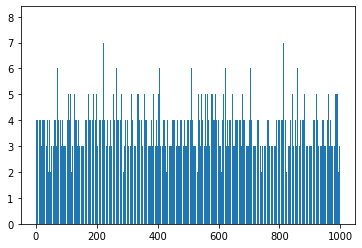

In [ ]:
%matplotlib inline
plt.bar(epochs,guesses)
plt.show()

In [ ]:
print(f'Average guesses: {np.mean(guesses)}')

Average guesses: 3.767


In [ ]:
print(f'Total game losses out of {training_epochs}: {np.sum(guesses>6)}')

Total game losses out of 1000: 8


In [ ]:
print(f'Overall win rate: {(training_epochs-np.sum(guesses>6))/training_epochs*100}%')

Overall win rate: 99.2%
